# Clustering  : cas pratique 

Le but de ce cas pratique est de réviser l'ensemble des algorithmes que nous avons vu ensemble dernièrement.  

## Les données 
Les données auxquelles nous nous intéressons sont celles de l'absentéisme dans une entreprise brésilienne. Les données sont dans le fichier csv `Absenteeism_at_work.csv` et leur description dans le fichier word `Attribute information`.   

## Première analyse en CAH  
Nous nous intéressons tout d'abord à essayer de regrouper les raisons de l'absence en moins de catégories qu'actuellement. Pour cela, nous allons mener une classification ascendante hiérarchique sur les variables explicatives de raisons de l'absence que nous avons à disposition. Nous allons utiliser l'ensemble des variables à notre disposition __sauf l'absentéisme en heures et les raisons de l'absence__.  

- Importez les données. Dans une nouvelle table stockez les variables qui nous intéressent et transformez les variables catégoriques en `dummies`.  


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN

from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

#pd.set_option('display.max_columns',100)
pd.options.display.max_columns = 40

In [2]:
#import des données
df0 = pd.read_csv('Absenteeism_at_work_AAA/Absenteeism_at_work.csv', sep=';')
df0.head()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26,7,3,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239.554,97,1,1,1,1,0,0,98,178,31,0
2,3,23,7,4,1,179,51,18,38,239.554,97,0,1,0,1,0,0,89,170,31,2
3,7,7,7,5,1,279,5,14,39,239.554,97,0,1,2,1,1,0,68,168,24,4
4,11,23,7,5,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,2


In [3]:
# suppression des doublons
df0.drop_duplicates(inplace=True)

In [4]:
# on garde les variables qui nous intéressent
df = df0.drop(['ID', 'Reason for absence', 'Seasons', 'Month of absence', 'Day of the week', 'Absenteeism time in hours'], axis=1)
df.head()

,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index
0,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30
1,118,13,18,50,239.554,97,1,1,1,1,0,0,98,178,31
2,179,51,18,38,239.554,97,0,1,0,1,0,0,89,170,31
3,279,5,14,39,239.554,97,0,1,2,1,1,0,68,168,24
4,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30


In [5]:
# création des dummies
df = pd.get_dummies(df, columns=['Education'])
df.head()

,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Education_1,Education_2,Education_3,Education_4
0,289,36,13,33,239.554,97,0,2,1,0,1,90,172,30,1,0,0,0
1,118,13,18,50,239.554,97,1,1,1,0,0,98,178,31,1,0,0,0
2,179,51,18,38,239.554,97,0,0,1,0,0,89,170,31,1,0,0,0
3,279,5,14,39,239.554,97,0,2,1,1,0,68,168,24,1,0,0,0
4,289,36,13,33,239.554,97,0,2,1,0,1,90,172,30,1,0,0,0


- Mettez l'ensemble des variables à la même échelle avec le `MinMaxScaler` de scikit learn, qui permet de mettre les variables continues à la même échelle que les `dummies`.

In [6]:
# MinMaxscaler ne modifie pas les dummies et permet de mettre les
# variables continues à la même échelle entre 0 et 1
sc = MinMaxScaler()
df_minmax = sc.fit_transform(df)

 
- Affichez le dendogramme d'une analyse CAH et justifiez un choix de nombre de classes.  


In [7]:
# On fait d'abord la matrice de liens : 
mat_lien = linkage(df_minmax, method='ward', metric='euclidean')
mat_lien

array([[   0.        ,    4.        ,    0.        ,    2.        ],
       [   2.        ,    5.        ,    0.        ,    2.        ],
       [  13.        ,  707.        ,    0.        ,    3.        ],
       ...,
       [1395.        , 1403.        ,   11.45758184,  120.        ],
       [1401.        , 1408.        ,   15.39013571,  300.        ],
       [1407.        , 1409.        ,   21.341099  ,  706.        ]])

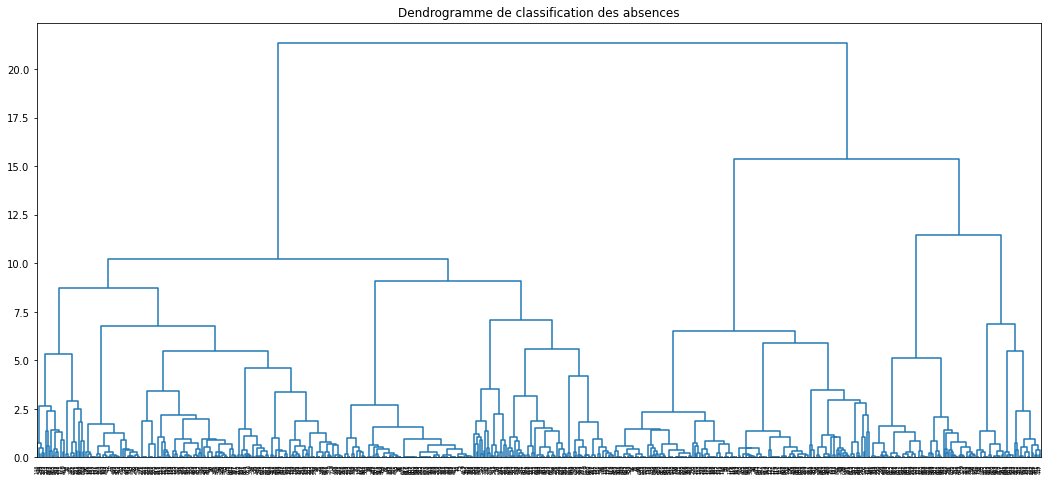

In [8]:
# Puis on peut afficher notre dendogramme : 
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(1,1,1)
ax.set_title("Dendrogramme de classification des absences")
dendrogram(mat_lien, orientation='top', color_threshold=0);

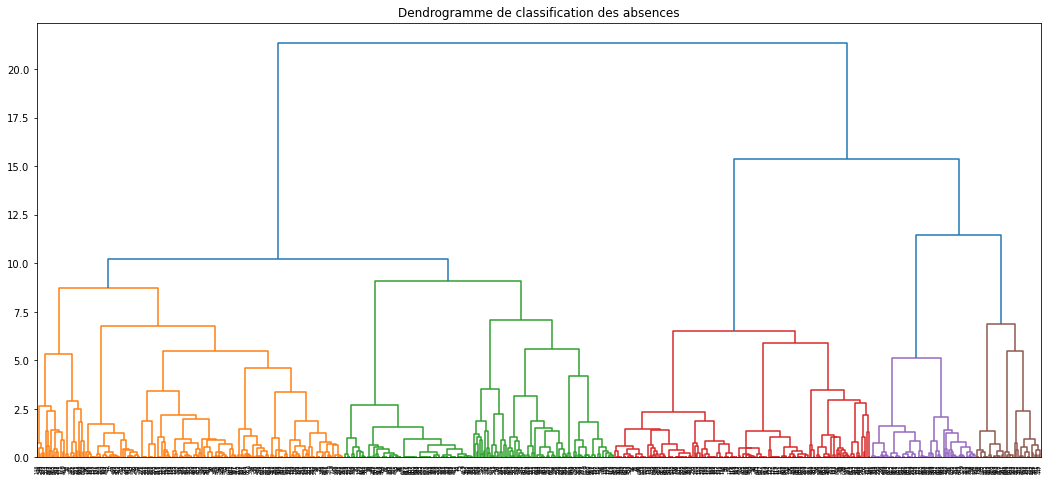

In [9]:
# On peut choisir 5 classes
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(1,1,1)
ax.set_title("Dendrogramme de classification des absences")
dendrogram(mat_lien, orientation='top', color_threshold=10);

- Procédez à la classification de vos données en fonction de ce nombre de classes.

In [10]:
# On crée les 5 classes
classes_cah = fcluster(mat_lien, t=10, criterion='distance')
np.unique(classes_cah, return_counts=True)

(array([1, 2, 3, 4, 5], dtype=int32), array([216, 190, 180,  74,  46]))

  - Affichez le tableau croisé des occurences des raisons pour l'absence et de vos classes obtenues. Y-a-t-il matière à faire un regroupement?

In [11]:
# on va regarder la répartition des motifs d'absences dans les classes
pd.crosstab(classes_cah, df0['Reason for absence'])

Reason for absence,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,21,22,23,24,25,26,27,28
row_0,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,9,4,0,1,1,0,1,6,1,2,9,4,1,16,10,2,0,0,5,21,0,25,31,3,2,14,0,48
2,25,2,0,0,0,2,2,0,0,0,5,7,2,18,3,0,0,0,5,6,2,1,35,0,4,11,24,36
3,5,3,0,0,1,1,4,6,3,2,7,9,2,7,5,0,0,0,4,9,0,4,57,0,12,4,12,23
4,1,5,0,0,0,0,1,2,0,0,1,2,2,13,1,0,1,0,3,1,2,4,15,0,6,2,11,1
5,3,2,1,0,0,0,0,1,2,0,3,4,1,1,0,0,2,1,4,3,2,3,4,0,7,2,0,0


## Réduction du nombre de dimensions du problème  : Analyse en Composantes Principales  

Nous allons maintenant tenter de mettre en oeuvre une ACP.  

- En affichant le graphique de l'évolution du ratio de la variance expliquée en fonction du nombre de composantes, justifiez du choix d'un nombre de composantes.  

In [12]:
# on commence par standardiser
df_std = StandardScaler().fit_transform(df)

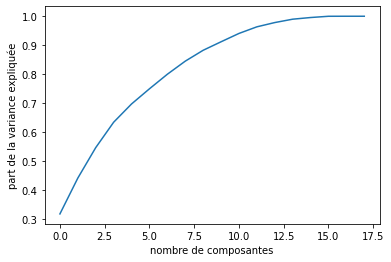

In [13]:
# graphique variance/nb de composantes
pca = PCA().fit(df_minmax)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('nombre de composantes')
plt.ylabel('part de la variance expliquée');

On voit qu'autour de 10 composantes, on expliqe environ 80% de la variance.

- Représentez graphiquement les points en fonction des deux premières composantes en colorant différemment selon la raison de l'absence. Trouve-t-on des regroupements qui coïncideraient avec les conclusions de la CAH?  Quel est le ratio de la variance expliqué par ces deux axes?  

La variance expliquée par les 2 premières composantes est 0.441692172556001


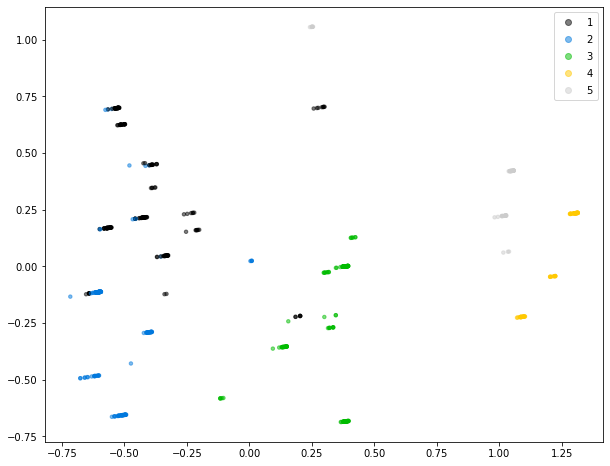

In [14]:
# on récupère la projection sur les composantes principales
X_pca = pca.transform(df_minmax)

# on trace les calasses obtenues par la CAH sur les 2 premières composantes
plt.figure(figsize=(10,8))
scat = plt.scatter(X_pca[:,0], X_pca[:,1],
                   c=classes_cah, cmap=plt.cm.get_cmap('nipy_spectral'),
                   alpha=0.5, s=12)
plt.legend(*scat.legend_elements());

# variance expliquée
print(f"La variance expliquée par les 2 premières composantes est {pca.explained_variance_ratio_[:2].sum()}")

## K-means et DBSCAN  
- Transformez les observations en fonction du nombre de classes voulues en utilisant d'abord un algorithme de k-means puis un DBSCAN. 

In [15]:
# on commence par standardiser avec un robust scaler pour tester la différence
df_rb = RobustScaler().fit_transform(df)

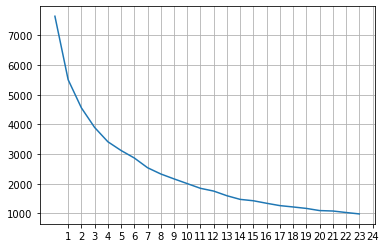

In [16]:
# quel nombre de classes choisir ?
inerties = []
for i in range(1,25):
    inerties.append(KMeans(n_clusters=i).fit(df_rb).inertia_)

plt.grid()
plt.plot(inerties)
plt.xticks(range(1,25));

On a envie de de dire que 4-5 classes c'est le mieux même si ça semble pas "évident" graphiquement.On peut utiliser avec les données projetées sur les axes de l'ACP.

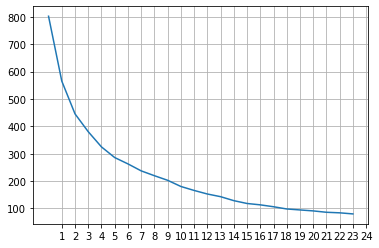

In [17]:
# avec les données projetées sur les 10 premières composantes principales
X_pca10 = X_pca[:,:10]
inerties = []
for i in range(1,25):
    inerties.append(KMeans(n_clusters=i).fit(X_pca10).inertia_)

plt.grid()
plt.plot(inerties)
plt.xticks(range(1,25));

C'est moins concluant pour le choix du nombre de classes pour le kmeans.

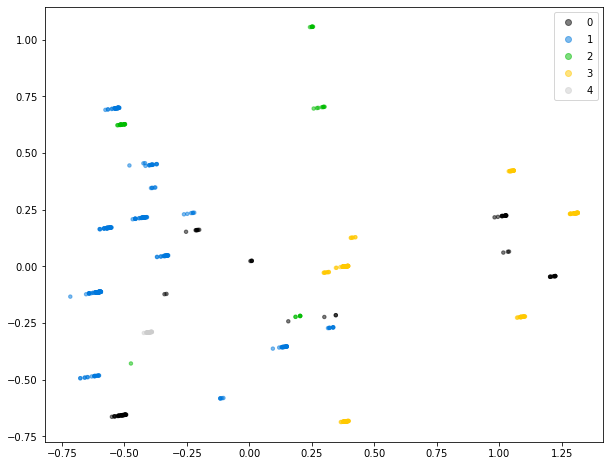

In [18]:
# on fait un kmeans sur les données avec robustscaler
classes_km_rb = KMeans(n_clusters=5).fit(df_rb).predict(df_rb)

# on trace les calasses obtenues par la CAH sur les 2 premières composantes
plt.figure(figsize=(10,8))
scat = plt.scatter(X_pca[:,0], X_pca[:,1],
                   c=classes_km_rb, cmap=plt.cm.get_cmap('nipy_spectral'),
                   alpha=0.5, s=12)
plt.legend(*scat.legend_elements());

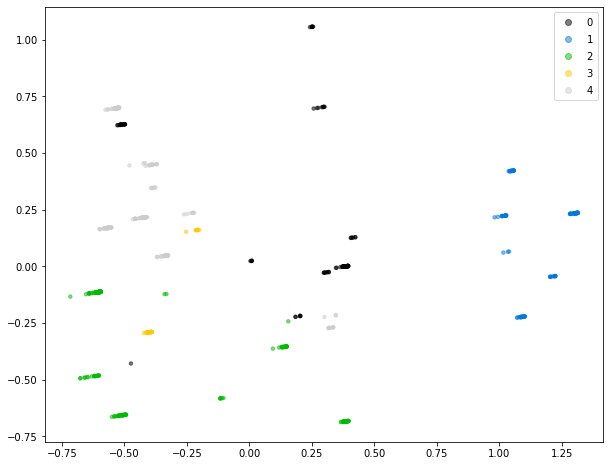

In [19]:
# on fait un kmeans sur les données avec standardscaler
classes_km_std = KMeans(n_clusters=5).fit(df_std).predict(df_std)

# on trace les calasses obtenues par la CAH sur les 2 premières composantes
plt.figure(figsize=(10,8))
scat = plt.scatter(X_pca[:,0], X_pca[:,1],
                   c=classes_km_std, cmap=plt.cm.get_cmap('nipy_spectral'),
                   alpha=0.5, s=12)
plt.legend(*scat.legend_elements());

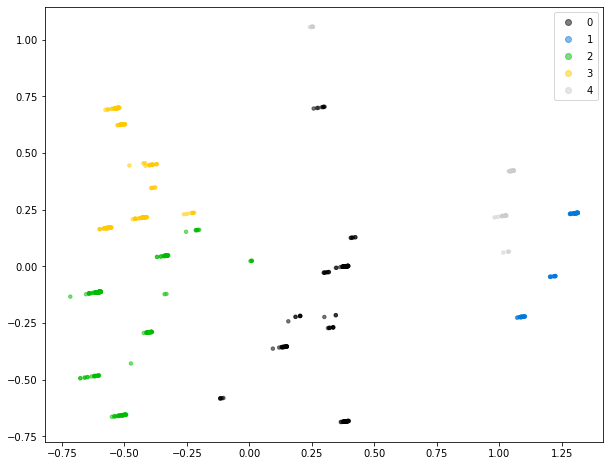

In [20]:
# on fait un kmeans sur les données avec PCA
classes_km_pca = KMeans(n_clusters=5).fit(X_pca10).predict(X_pca10)

# on trace les calasses obtenues par la CAH sur les 2 premières composantes
plt.figure(figsize=(10,8))
scat = plt.scatter(X_pca[:,0], X_pca[:,1],
                   c=classes_km_pca, cmap=plt.cm.get_cmap('nipy_spectral'),
                   alpha=0.5, s=12)
plt.legend(*scat.legend_elements());

In [21]:
# on va maintenant faire un dbscan
dist = pd.DataFrame(pdist(df_rb), columns=['df_rb'])
dist['df_std'] = pdist(df_std)
dist['pca'] = pdist(X_pca10)

dist.describe()

,df_rb,df_std,pca
count,248865.000000,248865.000000,248865.000000
mean,4.211841,5.661270,1.420129
std,1.983360,2.000274,0.508391
min,0.000000,0.000000,0.000000
25%,3.042085,4.383983,1.086439
50%,3.649325,5.660117,1.430932
75%,5.053955,6.839787,1.804009
max,12.863502,16.163548,2.731872


In [22]:
# on fait un premier dbscan "à vue"
db = DBSCAN(eps=3, min_samples=15)
classes_db_pca = db.fit_predict(X_pca10)
np.unique(classes_db_pca)

array([0])

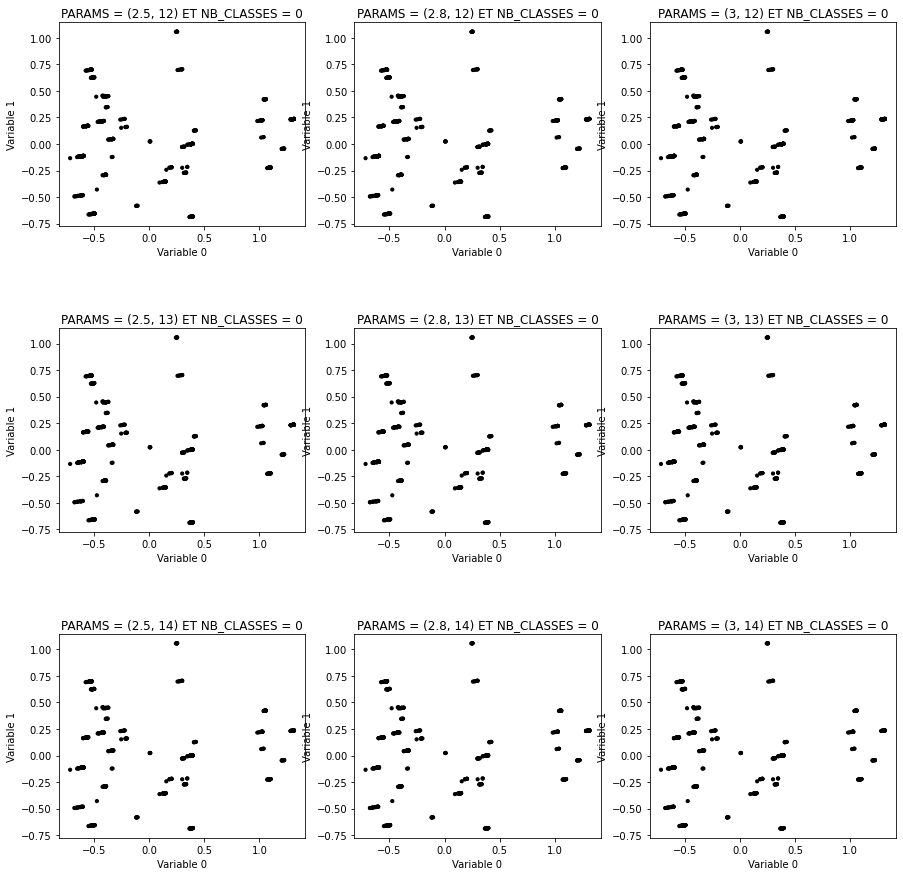

In [23]:
# pas très concluant donc on va regarder les meilleurs paramètres sachant qu'on veut essayer d'obtenir 4-5 classes
predicted_labels = []
params = []
for min_samples in [12, 13, 14]:
    for eps in [2.5, 2.8, 3]:
        db = DBSCAN(eps=eps ,min_samples=min_samples).fit(X_pca10)
        predicted_labels.append(db.labels_)
        params.append((eps, min_samples))

fig = plt.figure(figsize=(15,15))
plt.subplots_adjust(hspace=0.5)

for i in range(len(params)):
    ax = fig.add_subplot(3,3,i+1)
    ax.scatter(X_pca[np.where(predicted_labels[i]!=-1), 0],
               X_pca[np.where(predicted_labels[i]!=-1), 1],
               c=predicted_labels[i][np.where(predicted_labels[i]!=-1)], s=10, cmap=plt.cm.get_cmap('nipy_spectral'))
    ax.set_xlabel("Variable 0")
    ax.set_ylabel("Variable 1")
    ax.set_title(f"PARAMS = {params[i]} ET NB_CLASSES = {len(np.unique(predicted_labels[i]))-1}")

In [24]:
# on conserve 4 classes avec les paramètres 3,14"
db = DBSCAN(eps=3, min_samples=15)
classes_db_pca = db.fit_predict(X_pca10)
np.unique(classes_db_pca)

array([0])

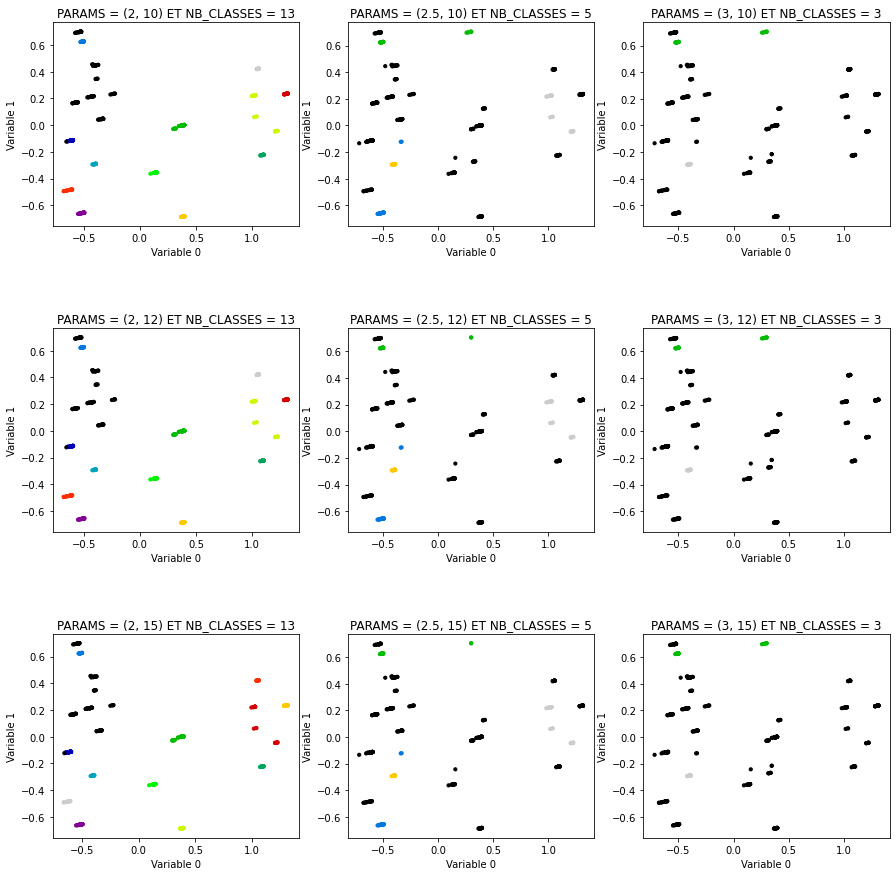

In [25]:
# en utilisant les données scalées avec le robustscaler
predicted_labels = []
params = []
for min_samples in [10, 12, 15]:
    for eps in [2, 2.5, 3]:
        db = DBSCAN(eps=eps ,min_samples=min_samples).fit(df_rb)
        predicted_labels.append(db.labels_)
        params.append((eps, min_samples))

fig = plt.figure(figsize=(15,15))
plt.subplots_adjust(hspace=0.5)

for i in range(len(params)):
    ax = fig.add_subplot(3,3,i+1)
    ax.scatter(X_pca[np.where(predicted_labels[i]!=-1), 0],
               X_pca[np.where(predicted_labels[i]!=-1), 1],
               c=predicted_labels[i][np.where(predicted_labels[i]!=-1)], s=10, cmap=plt.cm.get_cmap('nipy_spectral'))
    ax.set_xlabel("Variable 0")
    ax.set_ylabel("Variable 1")
    ax.set_title(f"PARAMS = {params[i]} ET NB_CLASSES = {len(np.unique(predicted_labels[i]))-1}")

In [26]:
# on conserve 4 classes avec les paramètres 2.5, 10
db = DBSCAN(eps=2.5, min_samples=10)
classes_db_rb = db.fit_predict(df_rb)
np.unique(classes_db_rb)

array([-1,  0,  1,  2,  3,  4])

- Comparez les résultats obtenus entre eux et avec la CAH.  

In [27]:
pd.crosstab(classes_cah, classes_db_pca)

col_0,0
row_0,
1,216
2,190
3,180
4,74
5,46


In [28]:
pd.crosstab(classes_cah, classes_db_rb)

col_0,-1,0,1,2,3,4
row_0,,,,,,
1,13,170,2,31,0,0
2,5,122,34,0,29,0
3,8,172,0,0,0,0
4,0,64,0,0,0,10
5,7,20,0,0,0,19


In [29]:
pd.crosstab(classes_cah, classes_km_pca)

col_0,0,1,2,3,4
row_0,,,,,
1,14,0,42,160,0
2,0,0,180,10,0
3,180,0,0,0,0
4,0,74,0,0,0
5,0,0,0,0,46


In [30]:
pd.crosstab(classes_cah, classes_km_rb)

col_0,0,1,2,3,4
row_0,,,,,
1,9,170,37,0,0
2,38,122,1,0,29
3,4,37,0,139,0
4,10,0,0,64,0
5,19,0,7,20,0


In [31]:
pd.crosstab(classes_cah, classes_km_std)

col_0,0,1,2,3,4
row_0,,,,,
1,37,0,8,7,164
2,5,0,145,29,11
3,89,0,80,0,11
4,0,74,0,0,0
5,7,39,0,0,0


## Caractérisations des classes  
On cherche à voir comment les variables "s'expriment" dans chaque classe : 

In [32]:
df0.drop(['ID',
          'Reason for absence',
          'Seasons', 'Month of absence',
          'Day of the week'], axis=1).groupby(classes_km_std).mean().round(2)

,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,252.73,33.53,8.19,30.20,275.72,94.93,0.05,1.14,1.10,0.25,0.10,2.84,71.83,170.17,24.68,5.35
1,219.10,19.54,10.61,33.17,268.06,95.42,0.04,2.65,0.56,0.00,0.18,0.20,70.01,173.39,23.11,5.88
2,170.73,31.05,15.72,41.23,267.54,94.36,0.06,1.00,0.47,0.66,0.01,0.17,90.36,170.96,31.06,5.56
3,155.39,14.92,12.44,33.03,292.36,95.31,0.03,1.00,1.61,1.00,0.19,0.00,91.11,193.86,24.42,14.08
4,281.80,32.68,12.81,37.87,273.62,93.83,0.08,1.00,1.97,0.94,0.06,0.48,73.23,170.36,25.11,9.88


On peut essayer de caractériser en fonction de leurs profils ainsi les 5 classes obtenues : 
- __classe 0__ : classe avec que des buveurs occasionnels et quelques fumeurs. Les absences y sont les plus longues : 13,2 heures en moyenne. Un nombre d'enfants moyen élevé (1,65) et des personnes de grandes taille mais avec un IMC correct...
- __classe 1__ : classe des plus diplômés. Pas buveur ni fumeur. Absences ne relevant quasiment jamais d'une faute disciplinaire et durée moyenne des absences la plus basse par rapport aux autres classes. IMC plus bas que la moyenne. Peu d'animaux et peu d'enfants en moyenne. Age moyen légérement plus jeune.
- __classe 2__ : majorité de buveurs occasionnels, très peu de fumeurs. IMC et poids supérieur à la moyenne. La distance moyenne de l'habitation au travail est assez élevée et l'absence résulte pour 6% des cas d'une faute de discipline. Ces absences sont plutôt moins longues en heures avec une moyenne de 6,56 heures. Personnes plus âgées que la moyenne. Niveau de diplôme faible. Peu d'enfants 0,49 enfants en moyenne et une durée moyenne de travail importante.
- __classe 3__ : comme pour la classe 2, majorité de buveurs occasionnels, très peu de fumeurs, distance habitation-travail élevée. En revanche, personnes plus jeunes, sans surpoids et avec un IMC relativement normal. Nombre moyen d'enfant élevé (1,76) et d'animaux de compagnie aussi (1,35). Temps d'absence relativement élevé en heures.
- __classe 4__ : niveau de diplôme moyen, avec en moyenne 1,02 enfant. Classe avec plus de fumeurs occasionnels que les autres et quelques buveurs occasionnels, avec un nombre moyen d'animaux assez élevé.

À croiser avec les raisons pour absence, comme fait plus haut!

Nombre de valeurs uniques d'ID par groupe : 

In [33]:
df0["ID"].groupby(classes_km_std).nunique()

0     9
1     6
2     9
3     2
4    10
Name: ID, dtype: int64

In [34]:
df0.drop(['ID',
          'Reason for absence',
          'Seasons', 'Month of absence',
          'Day of the week'], axis=1).groupby(classes_db_rb).mean().round(2)

,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
-1,235.36,32.70,11.09,39.61,271.82,94.88,0.12,1.58,0.67,0.58,0.39,3.39,83.97,176.09,27.18,4.33
0,221.08,30.56,12.89,36.26,271.43,94.41,0.04,1.27,1.08,0.53,0.06,0.56,76.79,169.90,26.58,6.76
1,118.00,13.11,18.33,49.78,270.97,94.50,0.17,1.00,1.06,1.00,0.06,0.00,96.72,177.83,30.67,9.08
2,365.39,51.23,5.06,30.06,269.67,94.55,0.10,1.00,1.26,0.74,0.26,4.00,76.13,172.52,25.45,7.03
3,155.00,12.00,14.00,34.00,299.35,95.69,0.00,1.00,2.00,1.00,0.00,0.00,95.00,196.00,25.00,16.41
4,290.83,15.48,5.79,29.90,261.52,95.79,0.10,2.34,0.00,0.00,0.00,0.00,80.38,180.21,25.00,6.07


Nombre de valeurs uniques d'ID par groupe : 

In [35]:
df0["ID"].groupby(classes_db_rb).nunique()

-1     7
 0    22
 1     2
 2     2
 3     1
 4     3
Name: ID, dtype: int64

Il y a donc 7 individus (pas observations) qui ne se voient pas attribuer de classes.

## Explication du temps d'absence   
On cherche maintenant à caractériser la longueur de l'absence, indépendemment de son motif.
- En reprenant l'analyse précédemment faite, regardez si le clustering peut aussi s'appliquer à la longueur de l'absence (absenteism in hours). Pour cela, regroupez cette variable en quelques classes que vous choisirez (pas d'absence - absence peu longue - absence longue - absence très longue). Pour déterminer les seuils qui discriminent le mieux les absences, vous pouvez utiliser une représentation graphique en fonction des deux premières composantes principales pour voir quelles nombres d'heures d'absence se trouvent aux mêmes endroits.


On peut essayer de voir comment se répartissent les longueurs d'absence sur nos deux premières composantes : 

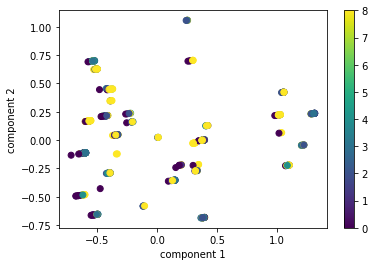

In [36]:
plt.scatter(X_pca[:, 0], X_pca[:, 1],
            c=df0["Absenteeism time in hours"],
           vmin = 0, vmax = 8)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();